In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import spearmanr
from scipy.stats import kendalltau

# Загрузка данных за полгода котировки SBER. (2023-06-01 -- 2023-12-31)

In [2]:
import psycopg2
from psycopg2 import sql
from config import db_settings

class PostgreSQLbase:
    def __init__(self, dbname, user, password, host):
        self.conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host)
        self.cursor = self.conn.cursor()

    def execute_query(self, query, columns_names = None):
        query = sql.SQL(query)
        self.cursor.execute(query)
        rows = self.cursor.fetchall()
        
        if columns_names:
            df = pd.DataFrame(rows, columns=columns_names)
        else:
            df = pd.DataFrame(rows)
        
        return df


db = PostgreSQLbase(db_settings['dbname'], db_settings['user'], db_settings['password'], db_settings['host'])


In [3]:
columns = ['ticker', 'date', 'close_price', 'price_change', 'price_change_percent', 'real_score']

query = """
SELECT 
	sq.ticker,
	sq.date,
	sq.close_price,
	ROUND(sq.close_price - LAG(sq.close_price) OVER (PARTITION BY sq.ticker ORDER BY sq.date),2) AS price_change,
    ROUND(((sq.close_price - LAG(sq.close_price) OVER (PARTITION BY sq.ticker ORDER BY sq.date)) / LAG(sq.close_price) OVER (PARTITION BY sq.ticker ORDER BY sq.date)) * 100,2) AS price_change_percent,
 	sn.real_score AS real_score
FROM 
	stocks_app.stock_quotes sq
LEFT JOIN (
	SELECT 
		* 
	FROM 
		stocks_app.stock_news
) sn ON 
	sq.ticker = sn.ticker 
	AND sq.date = sn.date
WHERE
	sq.ticker = 'SBER'
	and sq.date >= '2023-06-01'
	and sq.date <= '2023-12-31';
"""

data = db.execute_query(query, columns)
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")
data['close_price'] = data['close_price'].astype(float)
data['price_change'] = data['price_change'].astype(float)
data['price_change_percent'] = data['price_change_percent'].astype(float)
data['real_score'] = data['real_score'].astype(float)

data.dropna(inplace=True)
data

,ticker,date,close_price,price_change,price_change_percent,real_score
1,SBER,2023-06-02,243.95,2.29,0.95,-0.959974
2,SBER,2023-06-05,237.12,-6.83,-2.80,-0.822261
3,SBER,2023-06-06,240.91,3.79,1.60,0.472339
4,SBER,2023-06-07,241.25,0.34,0.14,0.932081
5,SBER,2023-06-08,241.77,0.52,0.22,0.929715
...,...,...,...,...,...,...
146,SBER,2023-12-25,271.08,-0.22,-0.08,0.926206
147,SBER,2023-12-26,271.90,0.82,0.30,-0.947043
148,SBER,2023-12-27,271.08,-0.82,-0.30,0.932041
149,SBER,2023-12-28,271.74,0.66,0.24,0.370977


In [4]:
df = data.copy()

# Удалим выбросы методом межквантильного размаха, чтобы подчистить данные от дивидендных гепов 

In [5]:

Q1 = df['price_change_percent'].quantile(0.25)
Q3 = df['price_change_percent'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price_change_percent'] >= lower_bound) & (df['price_change_percent'] <= upper_bound)]

print("Размер данных до удаления выбросов:", data.shape)
print("Размер данных после удаления выбросов:", df.shape)


Размер данных до удаления выбросов: (149, 6)
Размер данных после удаления выбросов: (142, 6)


# Проверка на нормальность

In [6]:
def check_distribution(column, column_name ="column", dist="norm", bins = 30):
    column = column.dropna()

    statistic, p_value = stats.normaltest(column)
    print(f"p-value for the normal test: {p_value}")

    if p_value > 0.05:
        print(f"Массив {column_name} имеет нормальное распределение.")
    else:
        print(f"Массив {column_name} не имеет нормального распределения.")

    plt.subplots(figsize=(15, 6))

    stats.probplot(column, dist="norm", plot=plt)
    plt.title(f"Q-Q plot for {column_name}")
    plt.show()
    
    plt.subplots(figsize=(15, 6))
    plt.hist(column, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Распределение {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()
    

p-value for the normal test: 0.9621063693664734
Массив price_change имеет нормальное распределение.


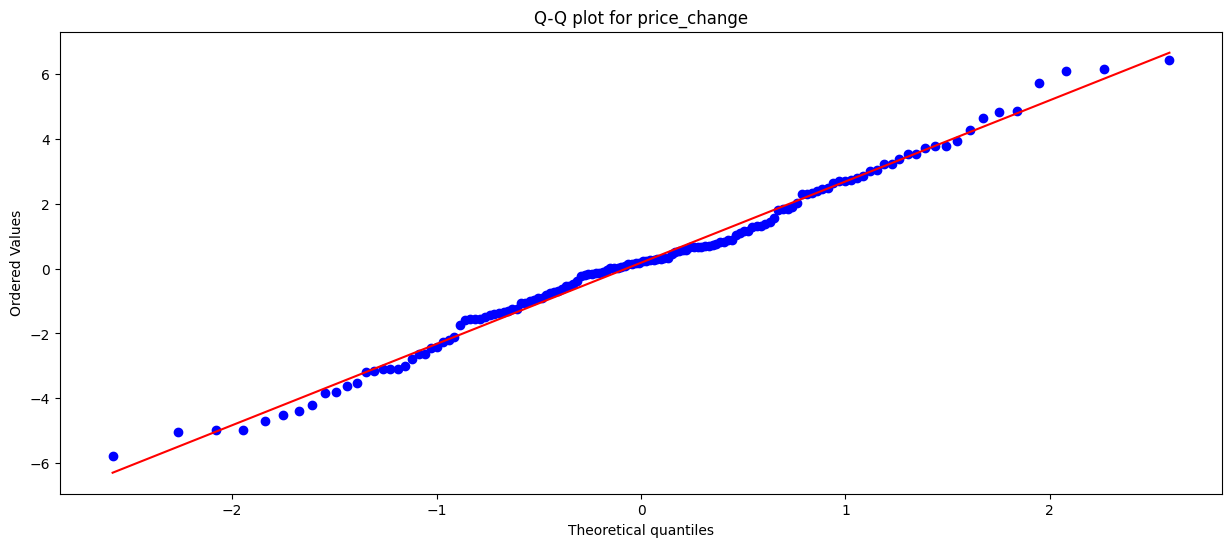

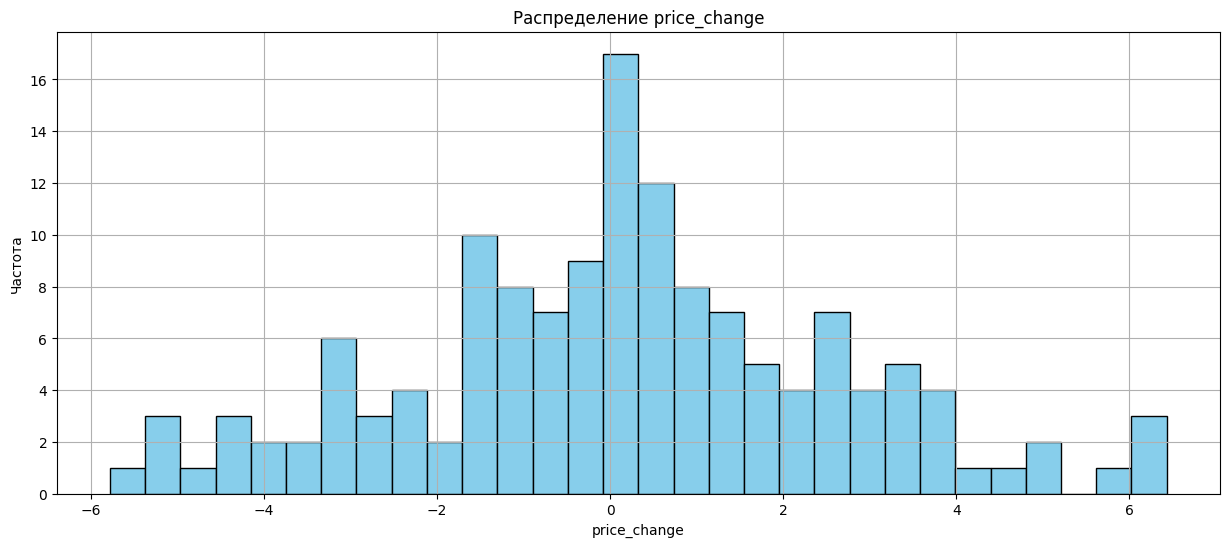

In [7]:
check_distribution(df['price_change'],column_name='price_change')

p-value for the normal test: 6.857109697274964e-25
Массив real_score не имеет нормального распределения.


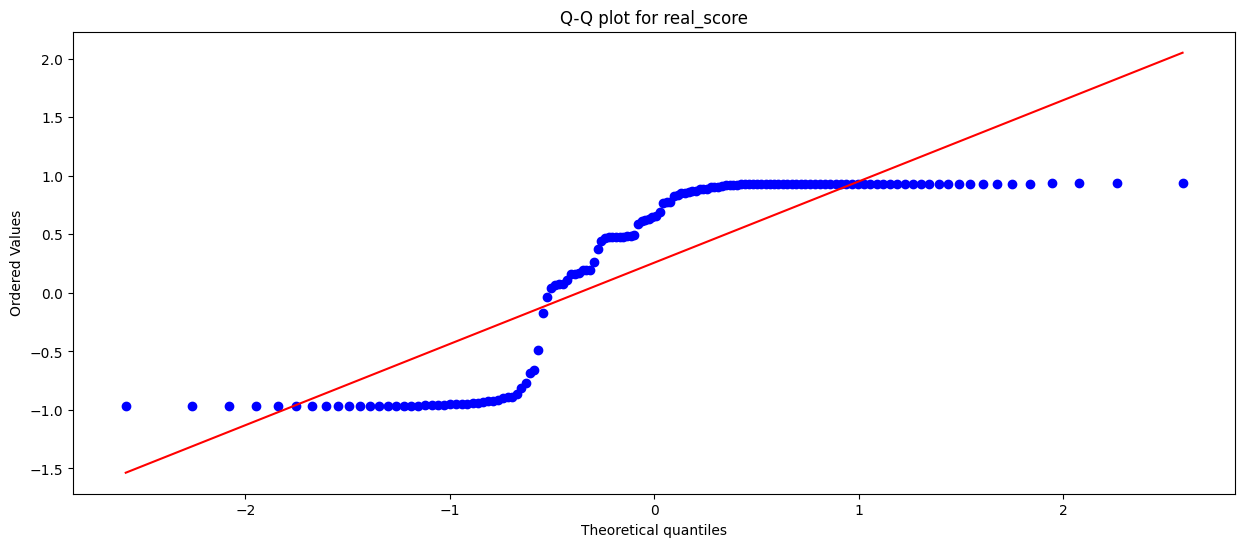

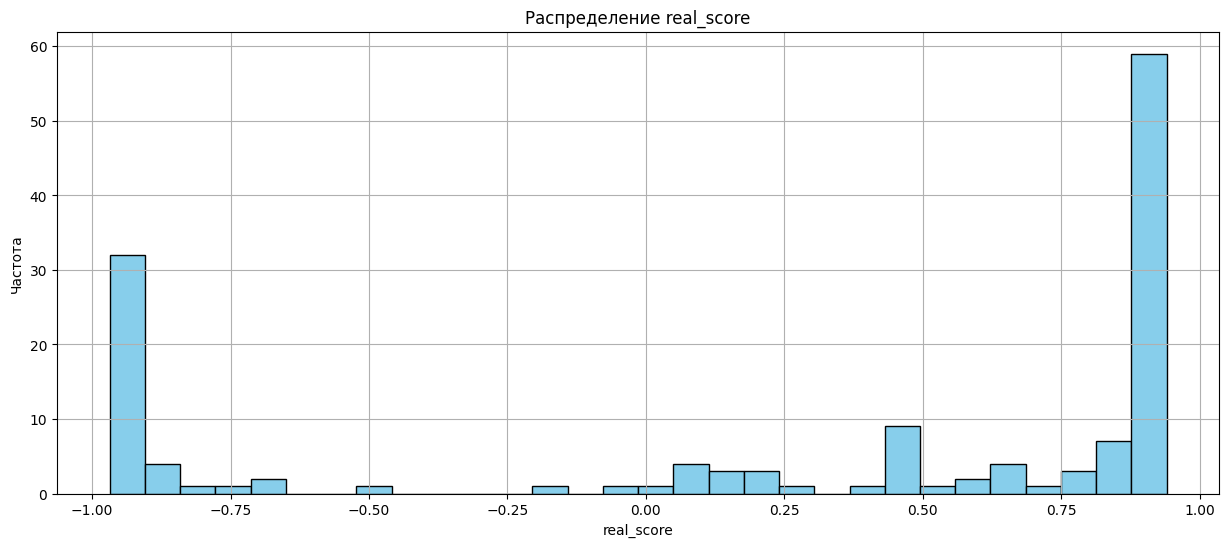

In [8]:
check_distribution(df['real_score'],column_name='real_score')

# Корреляционный анализ

In [9]:
def corr_analysis(col1,col2, col1_name = "Column 1", col2_name = "Column 2"):
    pirson_correlation = col1.corr(col2)
    print(f"Коэффициент корреляции Пирсона между {col1_name} и {col2_name}:", pirson_correlation)
    print()
    
    spearman_corr, p_value = spearmanr(col1,col2)
    print(f"Коэффициент Спирмена между {col1_name} и {col2_name}:", spearman_corr)
    print("p-value:", p_value)
    print()
    
    kendall_corr, p_value = kendalltau(col1,col2)
    print(f"Коэффициент между {col1_name} и {col2_name}:", kendall_corr)
    print("p-value:", p_value)

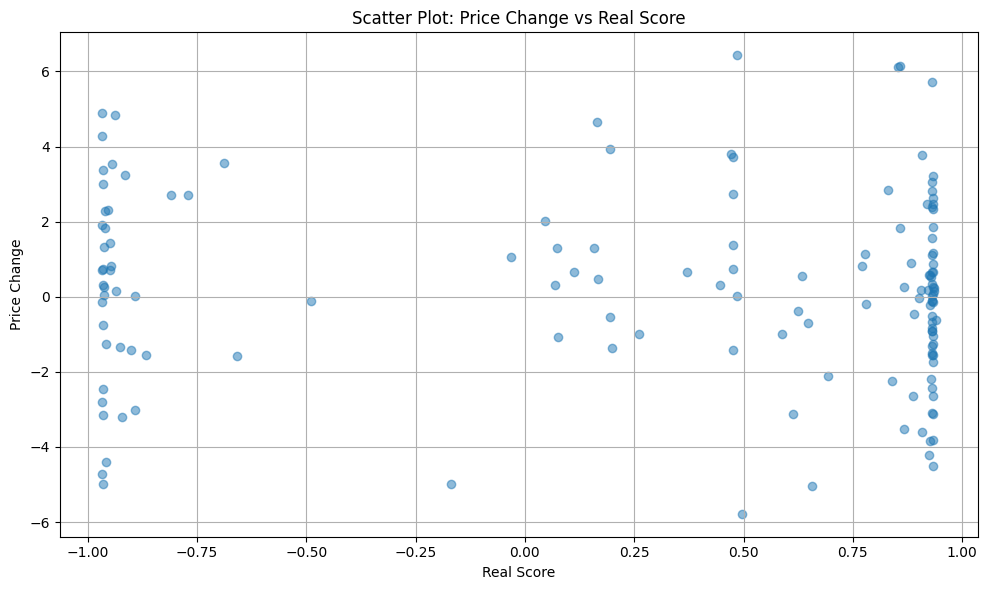

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df['real_score'], df['price_change'], alpha=0.5)
plt.title('Scatter Plot: Price Change vs Real Score')
plt.xlabel('Real Score')
plt.ylabel('Price Change')
plt.grid(True)
plt.tight_layout()
plt.show()

## Проверим корреляцию приращений цены "сегодня" от новости "сегодня"

In [11]:
corr_analysis(df['price_change'],df['real_score'], col1_name='price_change', col2_name='real_score')

Коэффициент корреляции Пирсона между price_change и real_score: -0.056781173428573896

Коэффициент Спирмена между price_change и real_score: -0.10679714400172607
p-value: 0.20586857960186025

Коэффициент между price_change и real_score: -0.07072121778018288
p-value: 0.21238605434130264


## Проверим корреляцию приращений цены через n дней от новости "сегодня"

In [12]:
n = 1
corr_analysis(df['price_change'].iloc[n:],df['real_score'].iloc[:-n], col1_name='price_change', col2_name='real_score')

Коэффициент корреляции Пирсона между price_change и real_score: -0.04552119410543319

Коэффициент Спирмена между price_change и real_score: -0.027206952650304986
p-value: 0.7487802172266176

Коэффициент между price_change и real_score: -0.018465909471097885
p-value: 0.7456142425990115


In [13]:
n = 2
corr_analysis(df['price_change'].iloc[n:],df['real_score'].iloc[:-n], col1_name='price_change', col2_name='real_score')

Коэффициент корреляции Пирсона между price_change и real_score: -0.04892458463895093

Коэффициент Спирмена между price_change и real_score: -0.20755975420610068
p-value: 0.01386578820889518

Коэффициент между price_change и real_score: -0.14429806810448584
p-value: 0.011540304285260407


In [14]:
n = 3
corr_analysis(df['price_change'].iloc[n:],df['real_score'].iloc[:-n], col1_name='price_change', col2_name='real_score')

Коэффициент корреляции Пирсона между price_change и real_score: -0.04726286378341463

Коэффициент Спирмена между price_change и real_score: -0.07728349271683205
p-value: 0.36584463496109343

Коэффициент между price_change и real_score: -0.05043333095250886
p-value: 0.37909369938838544


# Введем новый атрибут duration_real_score_n,  который будем считать как скольящее среднее по предыдущим n дням (пердполагая, что новость в n дней имеет вес).

In [15]:
real_score = list(df['real_score'])

In [16]:
for n in range(0,7):
    duration_real_score = [real_score[i] for i in range(n)]
    for i in range(n, len(real_score)):
        temp_sum = 0
        for j in range(n):
            temp_sum += real_score[i-j-1]
        duration_real_score+=[(temp_sum+real_score[i])/(n+1)]

    df[f'duration_real_score_{n+1}'] = duration_real_score

In [17]:
df[['duration_real_score_1', 'duration_real_score_2', 'duration_real_score_3', 'duration_real_score_4', 'duration_real_score_5', 'duration_real_score_7']]

,duration_real_score_1,duration_real_score_2,duration_real_score_3,duration_real_score_4,duration_real_score_5,duration_real_score_7
1,-0.959974,-0.959974,-0.959974,-0.959974,-0.959974,-0.959974
3,0.472339,-0.243817,0.472339,0.472339,0.472339,0.472339
4,0.932081,0.702210,0.148149,0.932081,0.932081,0.932081
5,0.929715,0.930898,0.778045,0.343540,0.929715,0.929715
6,0.198160,0.563938,0.686652,0.633074,0.314464,0.198160
...,...,...,...,...,...,...
146,0.926206,0.889721,0.292875,-0.021250,0.169654,0.386005
147,-0.947043,-0.010419,0.277466,-0.017105,-0.206409,0.117442
148,0.932041,-0.007501,0.303735,0.441110,0.172725,0.119038
149,0.370977,0.651509,0.118658,0.320545,0.427083,0.038711


In [18]:
df[['duration_real_score_1', 'duration_real_score_2', 'duration_real_score_3', 'duration_real_score_4', 'duration_real_score_5', 'duration_real_score_7']].describe()

,duration_real_score_1,duration_real_score_2,duration_real_score_3,duration_real_score_4,duration_real_score_5,duration_real_score_7
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,0.257499,0.250837,0.252217,0.254526,0.258544,0.255097
std,0.792620,0.581458,0.480430,0.410422,0.370408,0.326432
min,-0.968167,-0.967301,-0.964983,-0.959974,-0.959974,-0.959974
25%,-0.851941,-0.059755,-0.030071,-0.016307,0.081722,0.083419
50%,0.651915,0.222965,0.292416,0.341623,0.311579,0.278094
75%,0.931427,0.805876,0.645059,0.503082,0.490727,0.479987
max,0.940421,0.935218,0.934117,0.933211,0.932973,0.932081


-------------------------------------------------------------------------------
-------------- Распределение и корреляция duration_real_score_1 ---------------
p-value for the normal test: 6.857109697274964e-25
Массив duration_real_score_1 не имеет нормального распределения.


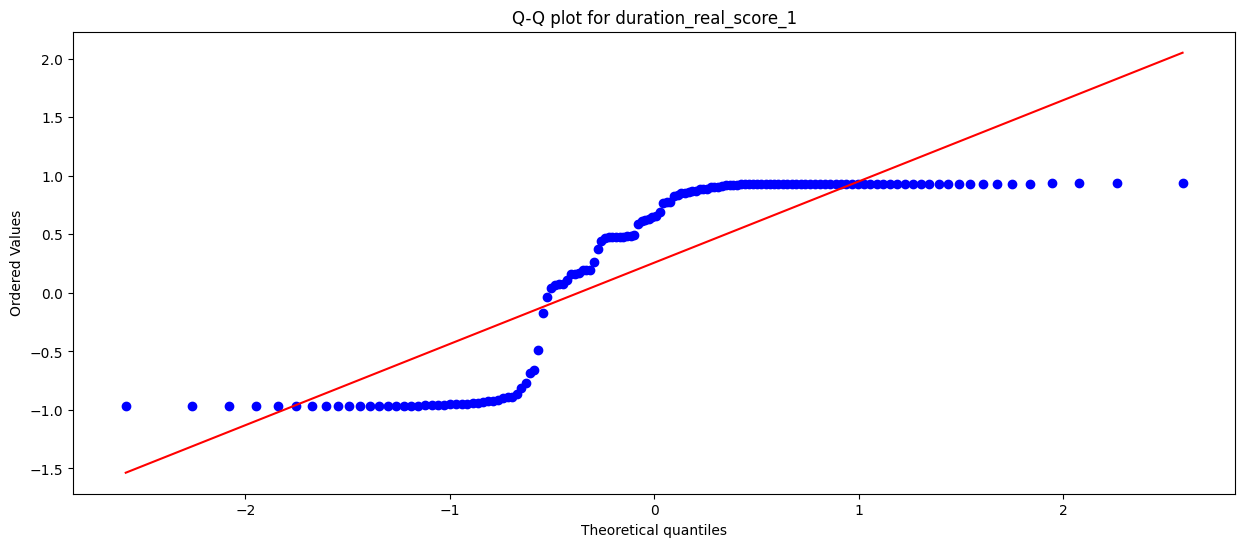

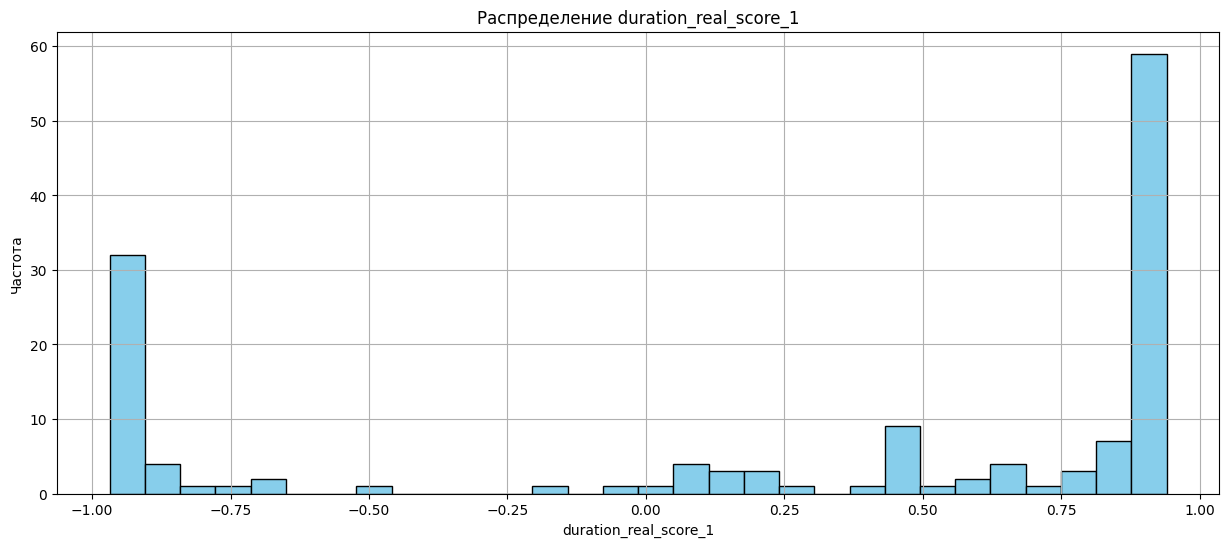

Коэффициент корреляции Пирсона между price_change и duration_real_score_1: -0.056781173428573896

Коэффициент Спирмена между price_change и duration_real_score_1: -0.10679714400172607
p-value: 0.20586857960186025

Коэффициент между price_change и duration_real_score_1: -0.07072121778018288
p-value: 0.21238605434130264


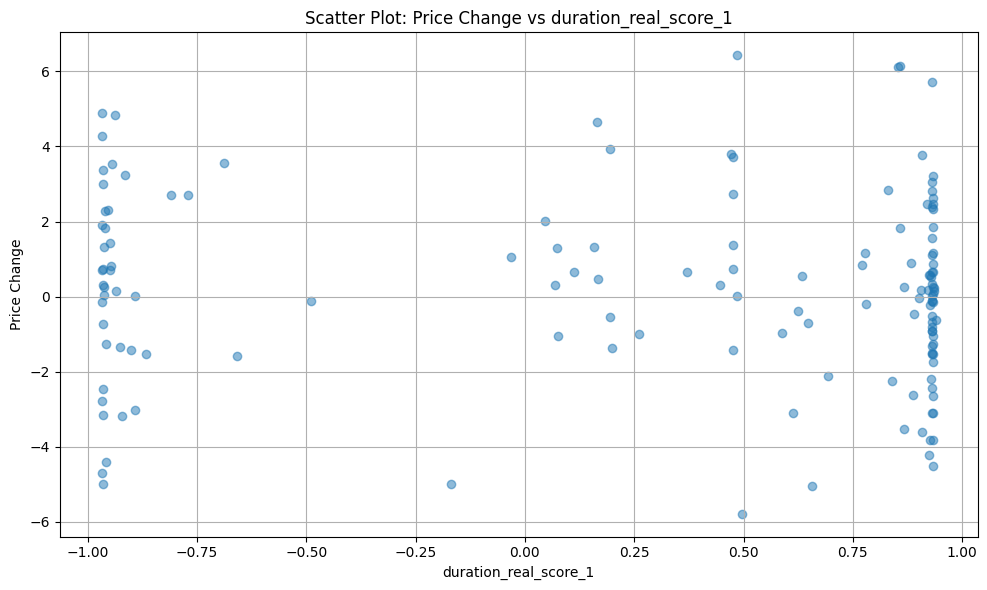



-------------------------------------------------------------------------------
-------------- Распределение и корреляция duration_real_score_2 ---------------
p-value for the normal test: 0.0035375871188210103
Массив duration_real_score_2 не имеет нормального распределения.


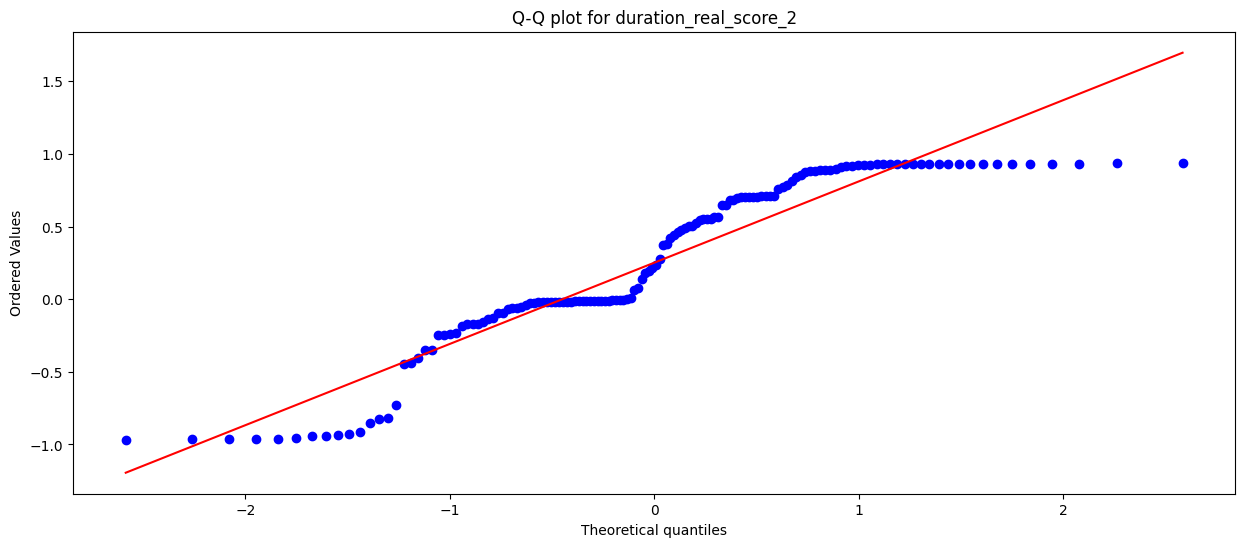

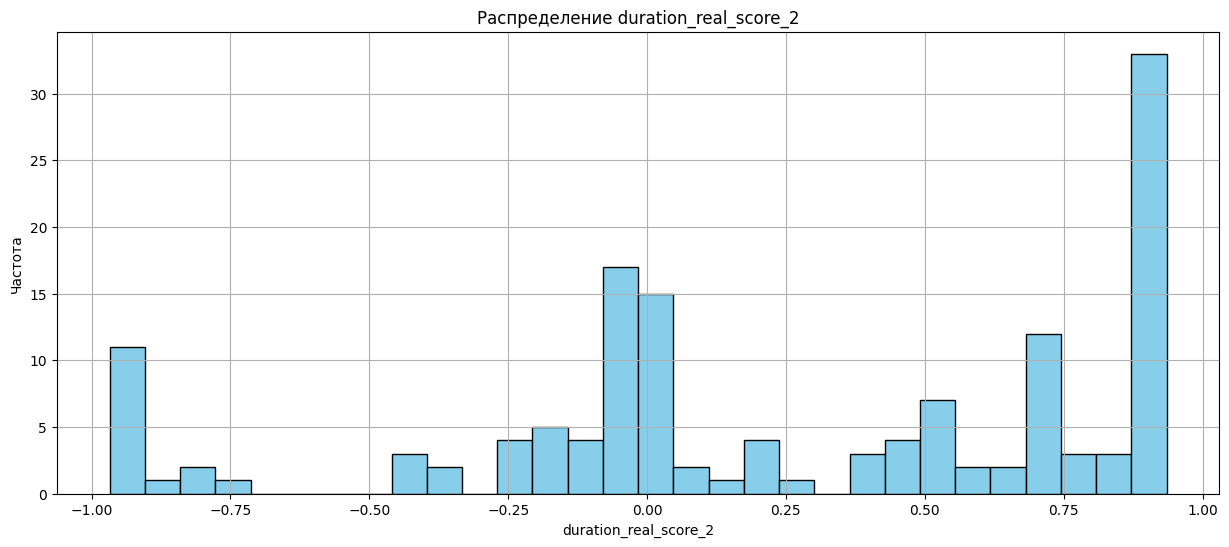

Коэффициент корреляции Пирсона между price_change и duration_real_score_2: -0.09187685379490462

Коэффициент Спирмена между price_change и duration_real_score_2: -0.10431659201070807
p-value: 0.2166585135046499

Коэффициент между price_change и duration_real_score_2: -0.07027893880087899
p-value: 0.21499762319906168


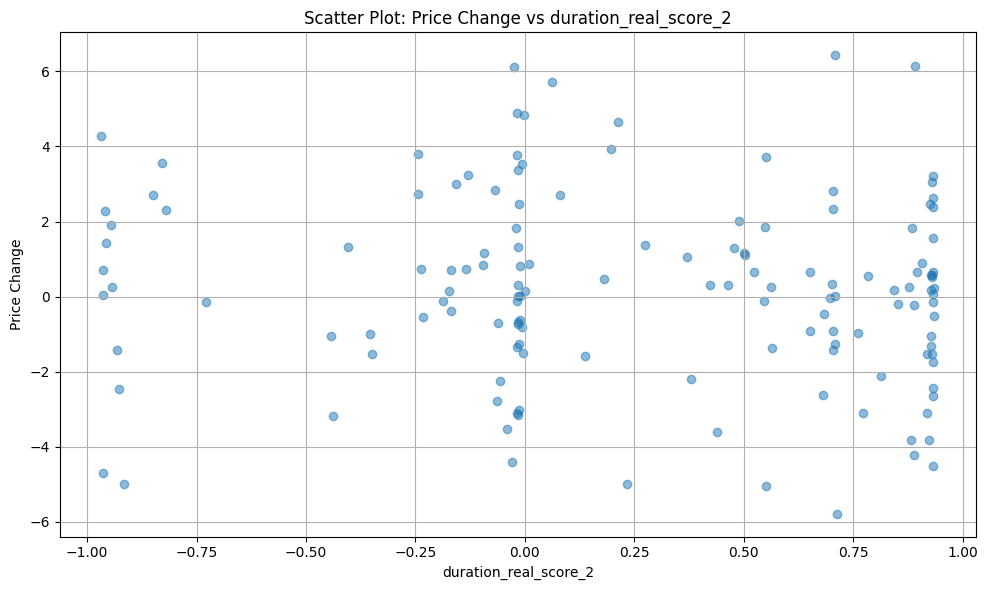



-------------------------------------------------------------------------------
-------------- Распределение и корреляция duration_real_score_3 ---------------
p-value for the normal test: 0.03849174741977481
Массив duration_real_score_3 не имеет нормального распределения.


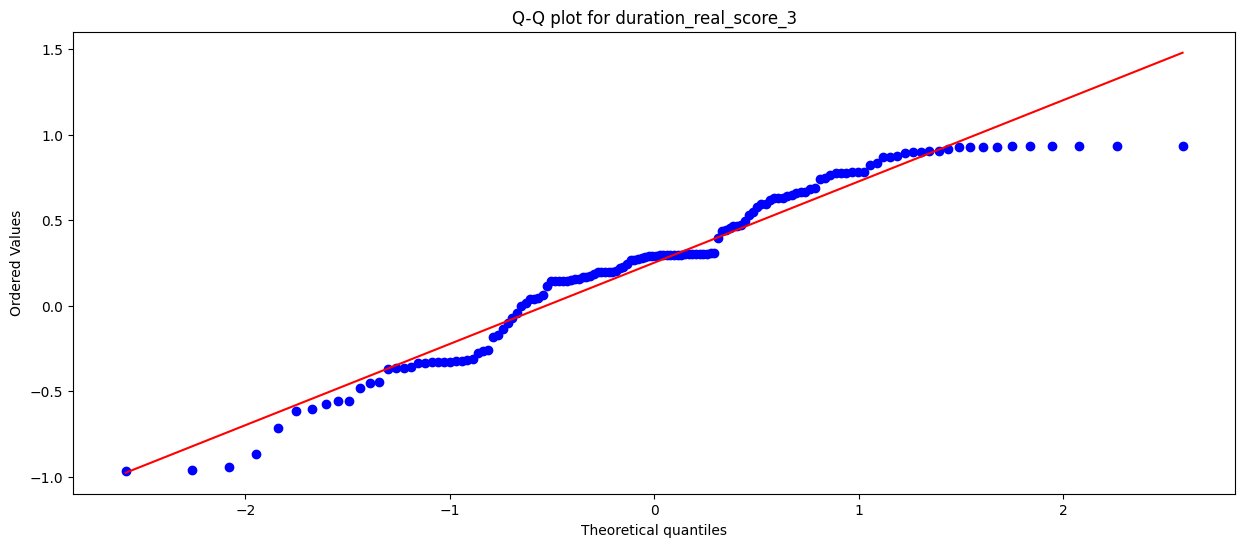

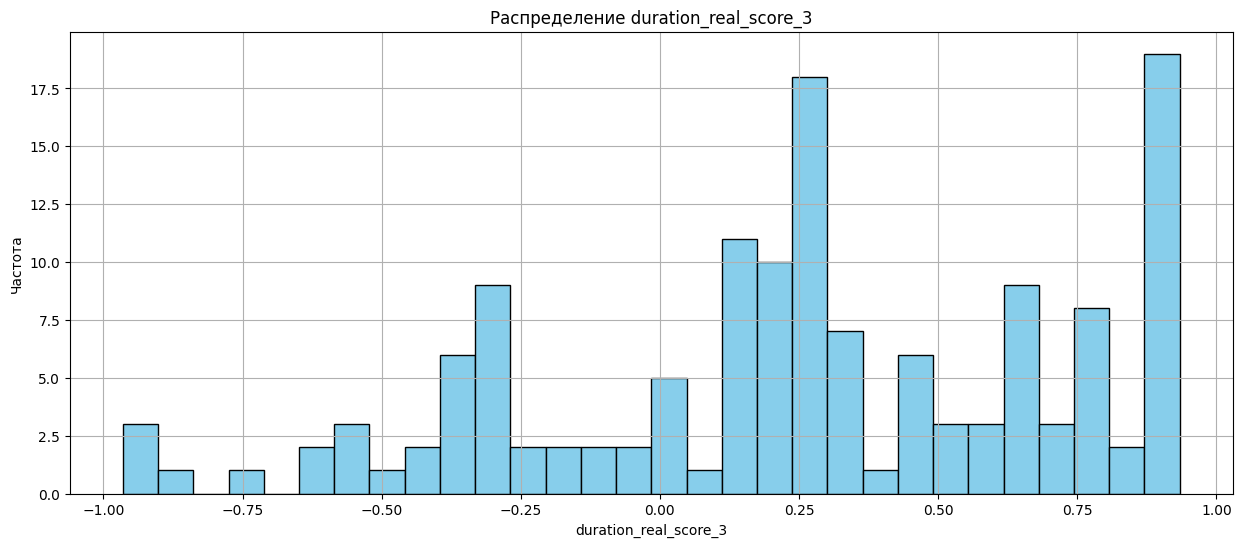

Коэффициент корреляции Пирсона между price_change и duration_real_score_3: -0.1806765766979732

Коэффициент Спирмена между price_change и duration_real_score_3: -0.19713861800472735
p-value: 0.018695896235600244

Коэффициент между price_change и duration_real_score_3: -0.13985808731497823
p-value: 0.013604755860129231


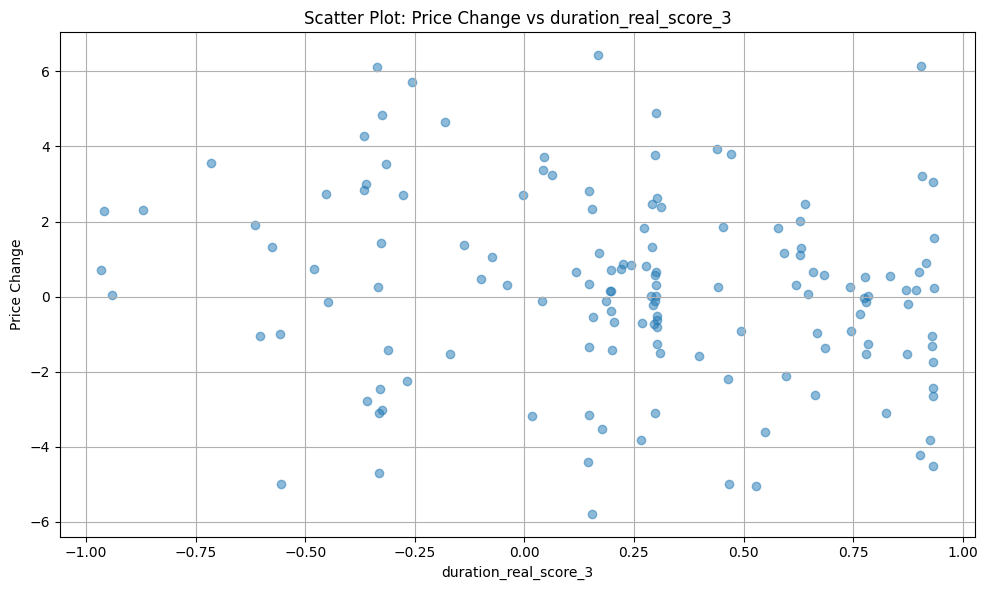



-------------------------------------------------------------------------------
-------------- Распределение и корреляция duration_real_score_4 ---------------
p-value for the normal test: 0.06492293803893441
Массив duration_real_score_4 имеет нормальное распределение.


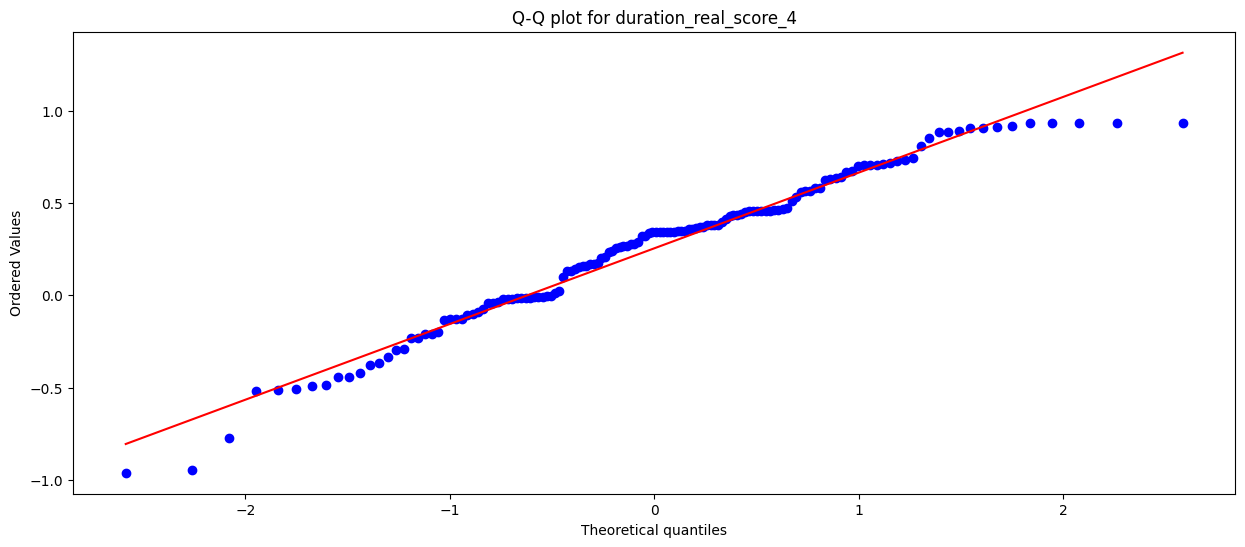

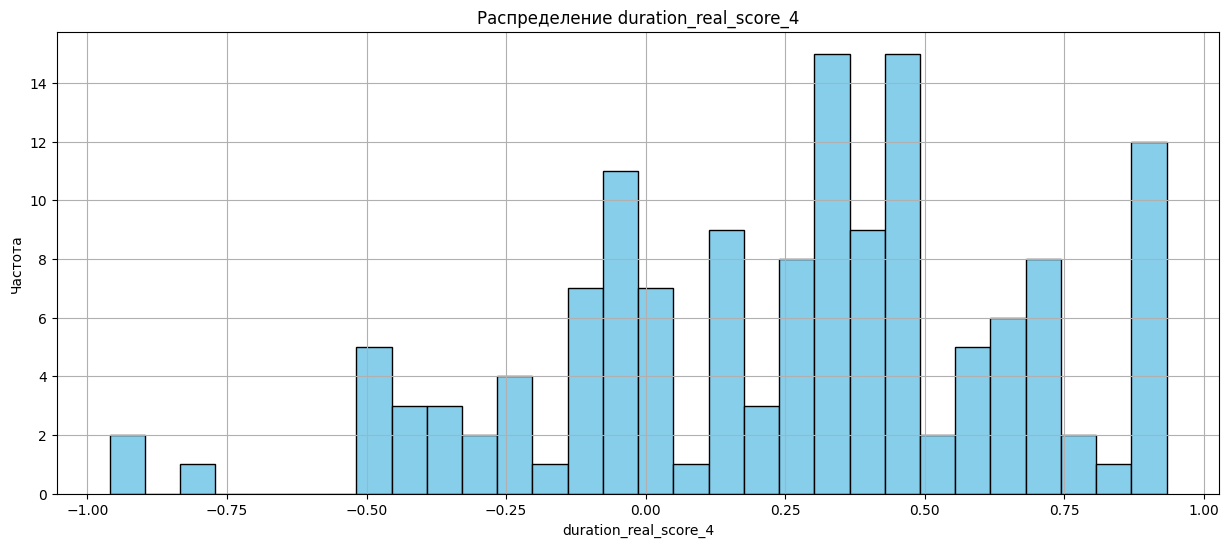

Коэффициент корреляции Пирсона между price_change и duration_real_score_4: -0.17677339189855396

Коэффициент Спирмена между price_change и duration_real_score_4: -0.1729635369625482
p-value: 0.039549654313158794

Коэффициент между price_change и duration_real_score_4: -0.11617098991744991
p-value: 0.04041131570269798


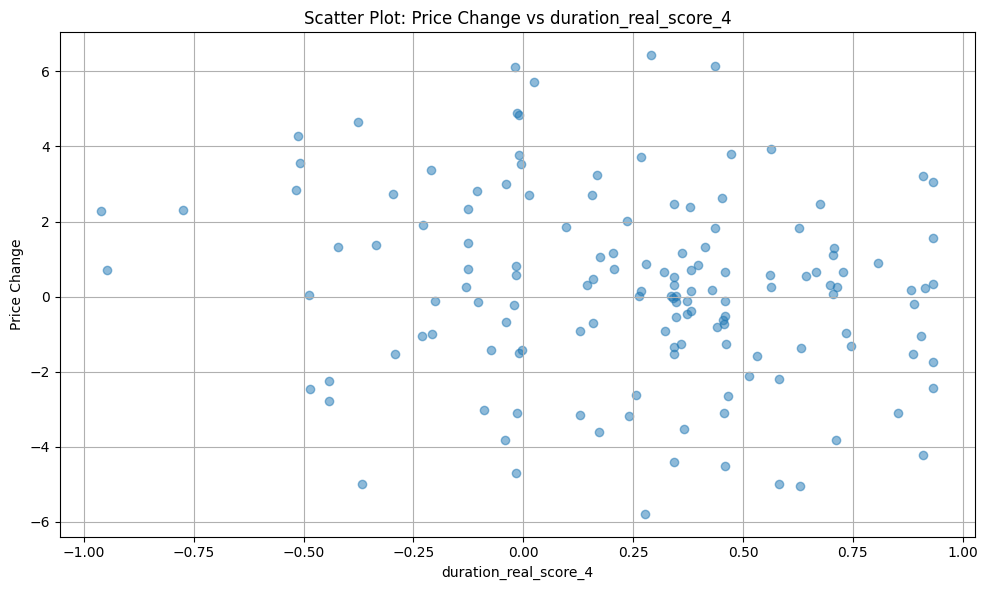



-------------------------------------------------------------------------------
-------------- Распределение и корреляция duration_real_score_5 ---------------
p-value for the normal test: 0.030280893337938715
Массив duration_real_score_5 не имеет нормального распределения.


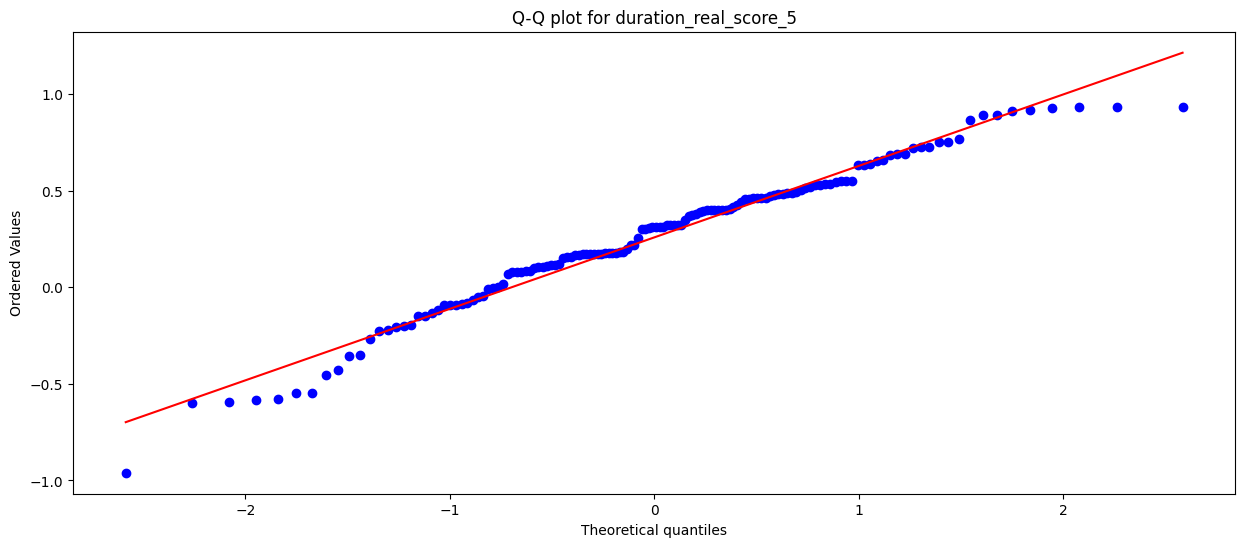

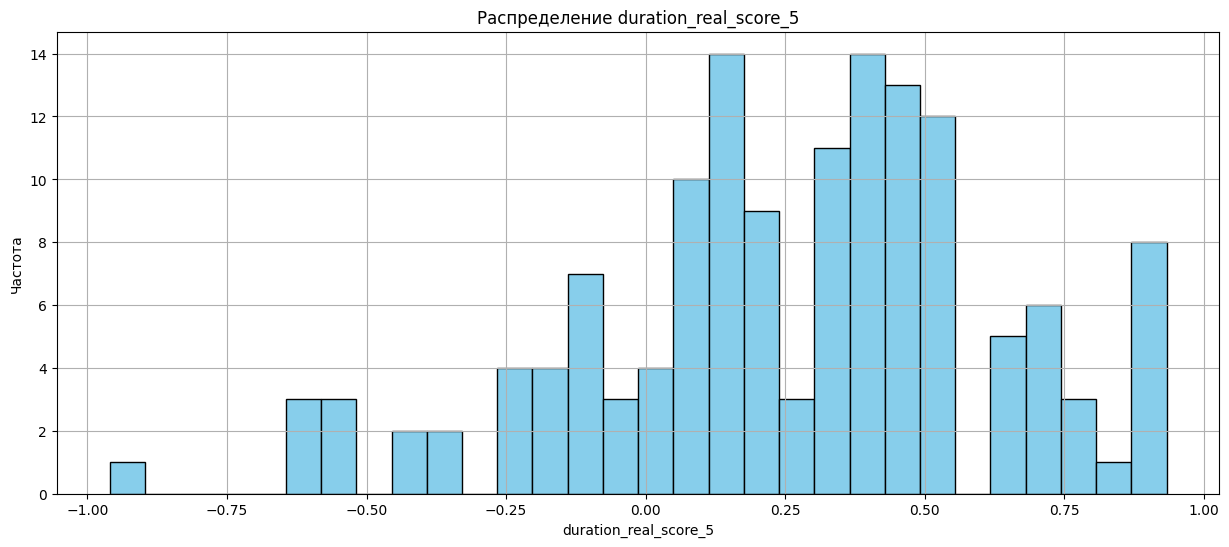

Коэффициент корреляции Пирсона между price_change и duration_real_score_5: -0.09577183969213741

Коэффициент Спирмена между price_change и duration_real_score_5: -0.08872524263528925
p-value: 0.29371318352366627

Коэффициент между price_change и duration_real_score_5: -0.05988803706222451
p-value: 0.29073541814799886


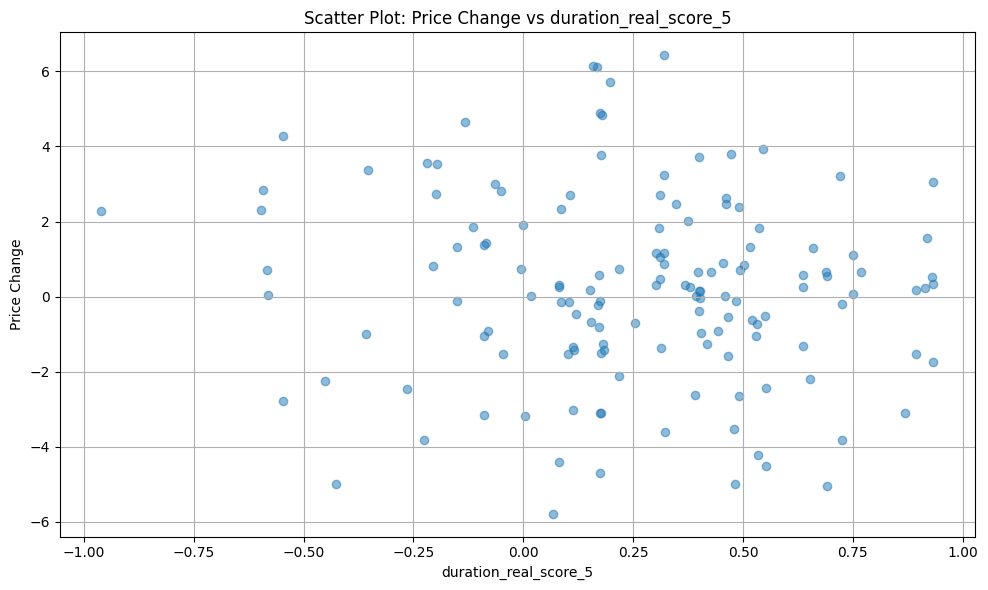



-------------------------------------------------------------------------------
-------------- Распределение и корреляция duration_real_score_6 ---------------
p-value for the normal test: 0.01540711642099764
Массив duration_real_score_6 не имеет нормального распределения.


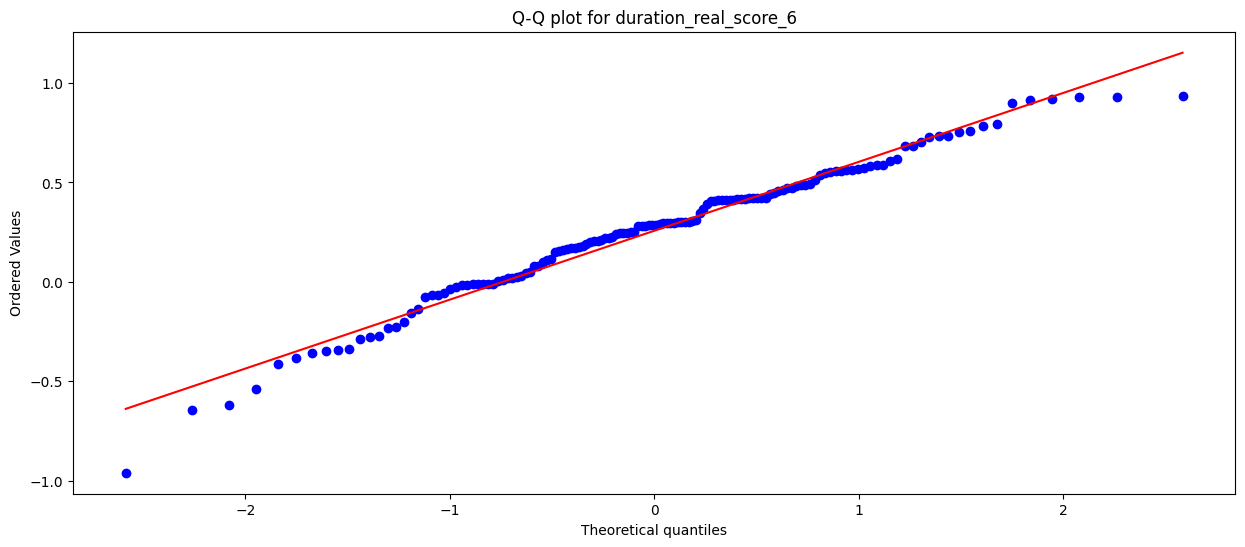

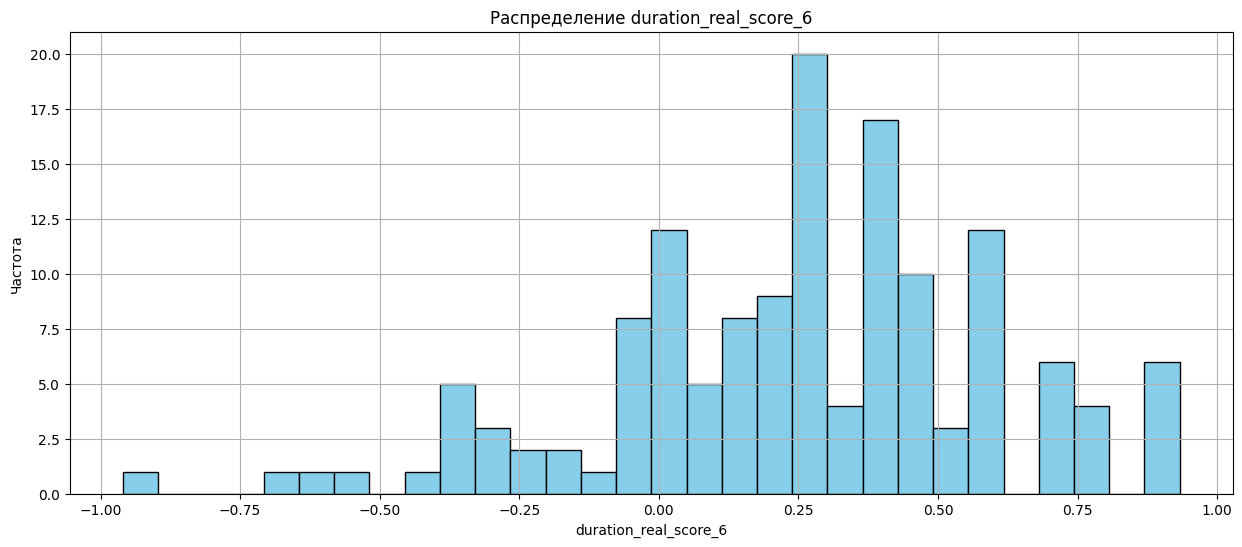

Коэффициент корреляции Пирсона между price_change и duration_real_score_6: -0.08423637501857772

Коэффициент Спирмена между price_change и duration_real_score_6: -0.09168419145952002
p-value: 0.27784458924232647

Коэффициент между price_change и duration_real_score_6: -0.06238442143587672
p-value: 0.2710696079596022


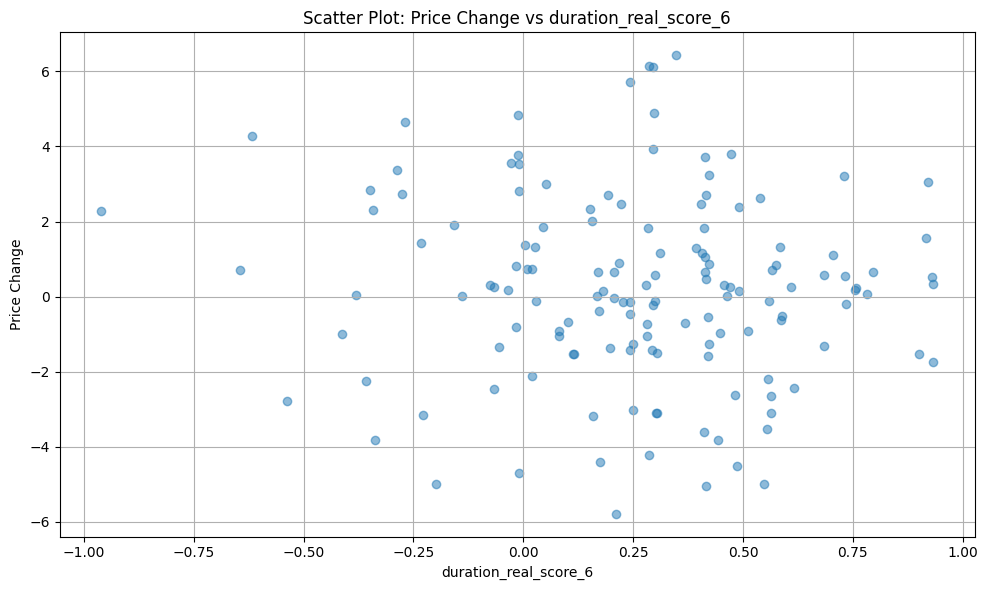



-------------------------------------------------------------------------------
-------------- Распределение и корреляция duration_real_score_7 ---------------
p-value for the normal test: 0.012977854572344997
Массив duration_real_score_7 не имеет нормального распределения.


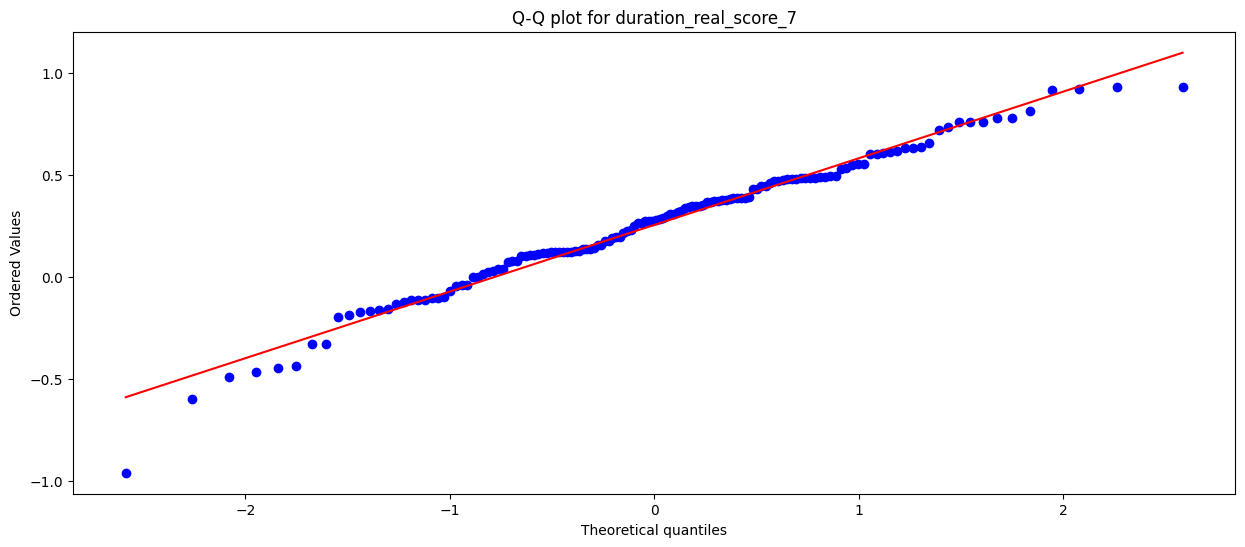

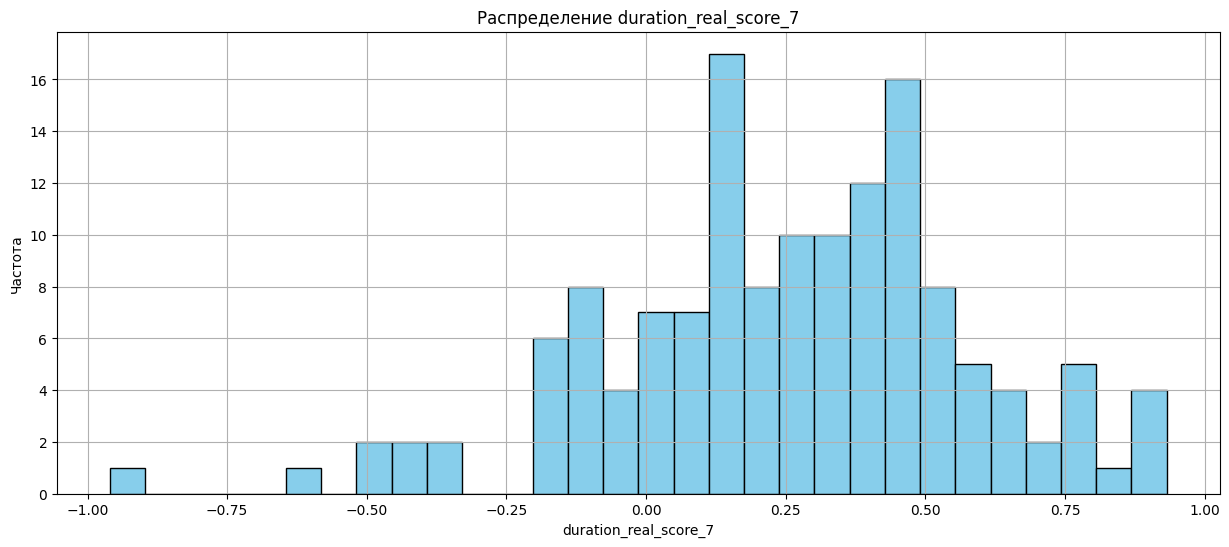

Коэффициент корреляции Пирсона между price_change и duration_real_score_7: -0.09562394535504476

Коэффициент Спирмена между price_change и duration_real_score_7: -0.09309236309814925
p-value: 0.27049933541861915

Коэффициент между price_change и duration_real_score_7: -0.05548337273753604
p-value: 0.32762942990150257


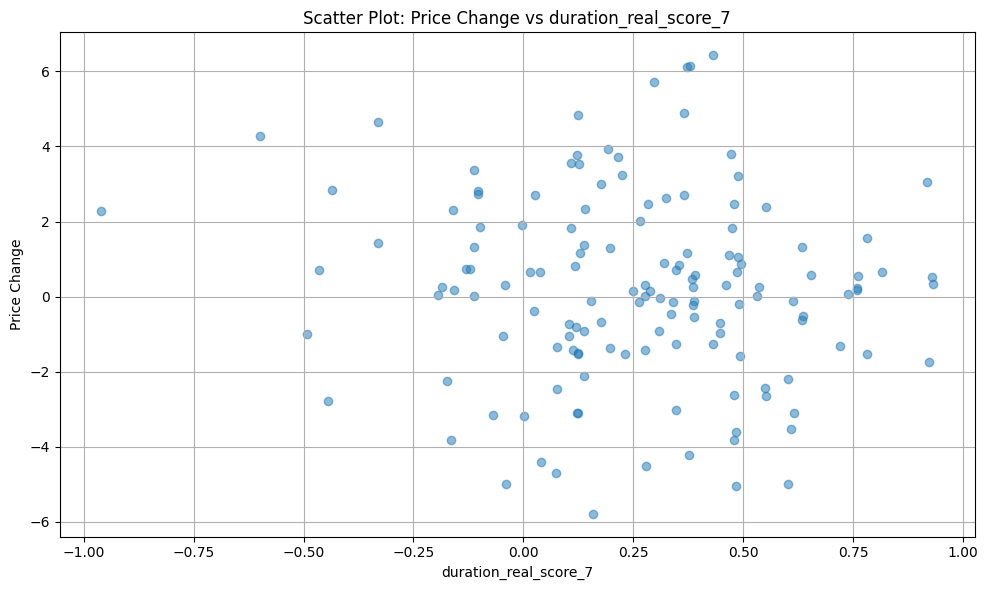

In [19]:
for n in range(0,7):
    print("-------------------------------------------------------------------------------")
    print(f'-------------- Распределение и корреляция duration_real_score_{n+1} ---------------')
    check_distribution(df[f'duration_real_score_{n+1}'],column_name=f'duration_real_score_{n+1}')
    corr_analysis(df['price_change'],df[f'duration_real_score_{n+1}'], col1_name='price_change', col2_name=f'duration_real_score_{n+1}')
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df[f'duration_real_score_{n+1}'], df['price_change'], alpha=0.5)
    plt.title(f'Scatter Plot: Price Change vs duration_real_score_{n+1}')
    plt.xlabel(f'duration_real_score_{n+1}')
    plt.ylabel('Price Change')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print()
    print()